## Imports

In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid


import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno


from utils import *

## Data 

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

| Feature | Description |
|---------|-------------|
| Pregnancies   | Number of times pregnant       |
| Glucose   | Plasma glucose concentration a 2 hours in an oral glucose tolerance test       |
| BloodPressure  | Diastolic blood pressure (mm Hg)      |
| SkinThickness   | Triceps skin fold thickness (mm)       |
| Insulin   | 2-Hour serum insulin (mu U/ml)       |
| BMI   | Body mass index (weight in kg/(height in m)^2)       |
| DiabetesPedigreeFunction   | Diabetes pedigree function       |
| Age   | Age (years)      |
| Outcome(Has Diabetes)   | Class variable (0(False) or 1(True))        |


In [2]:
dataset = np.loadtxt('data/pima-indians-diabetes.csv', delimiter=',')

cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
df = pd.DataFrame(dataset,columns=cols)

X = dataset[:,0:8]
y = dataset[:,8]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


### EDA

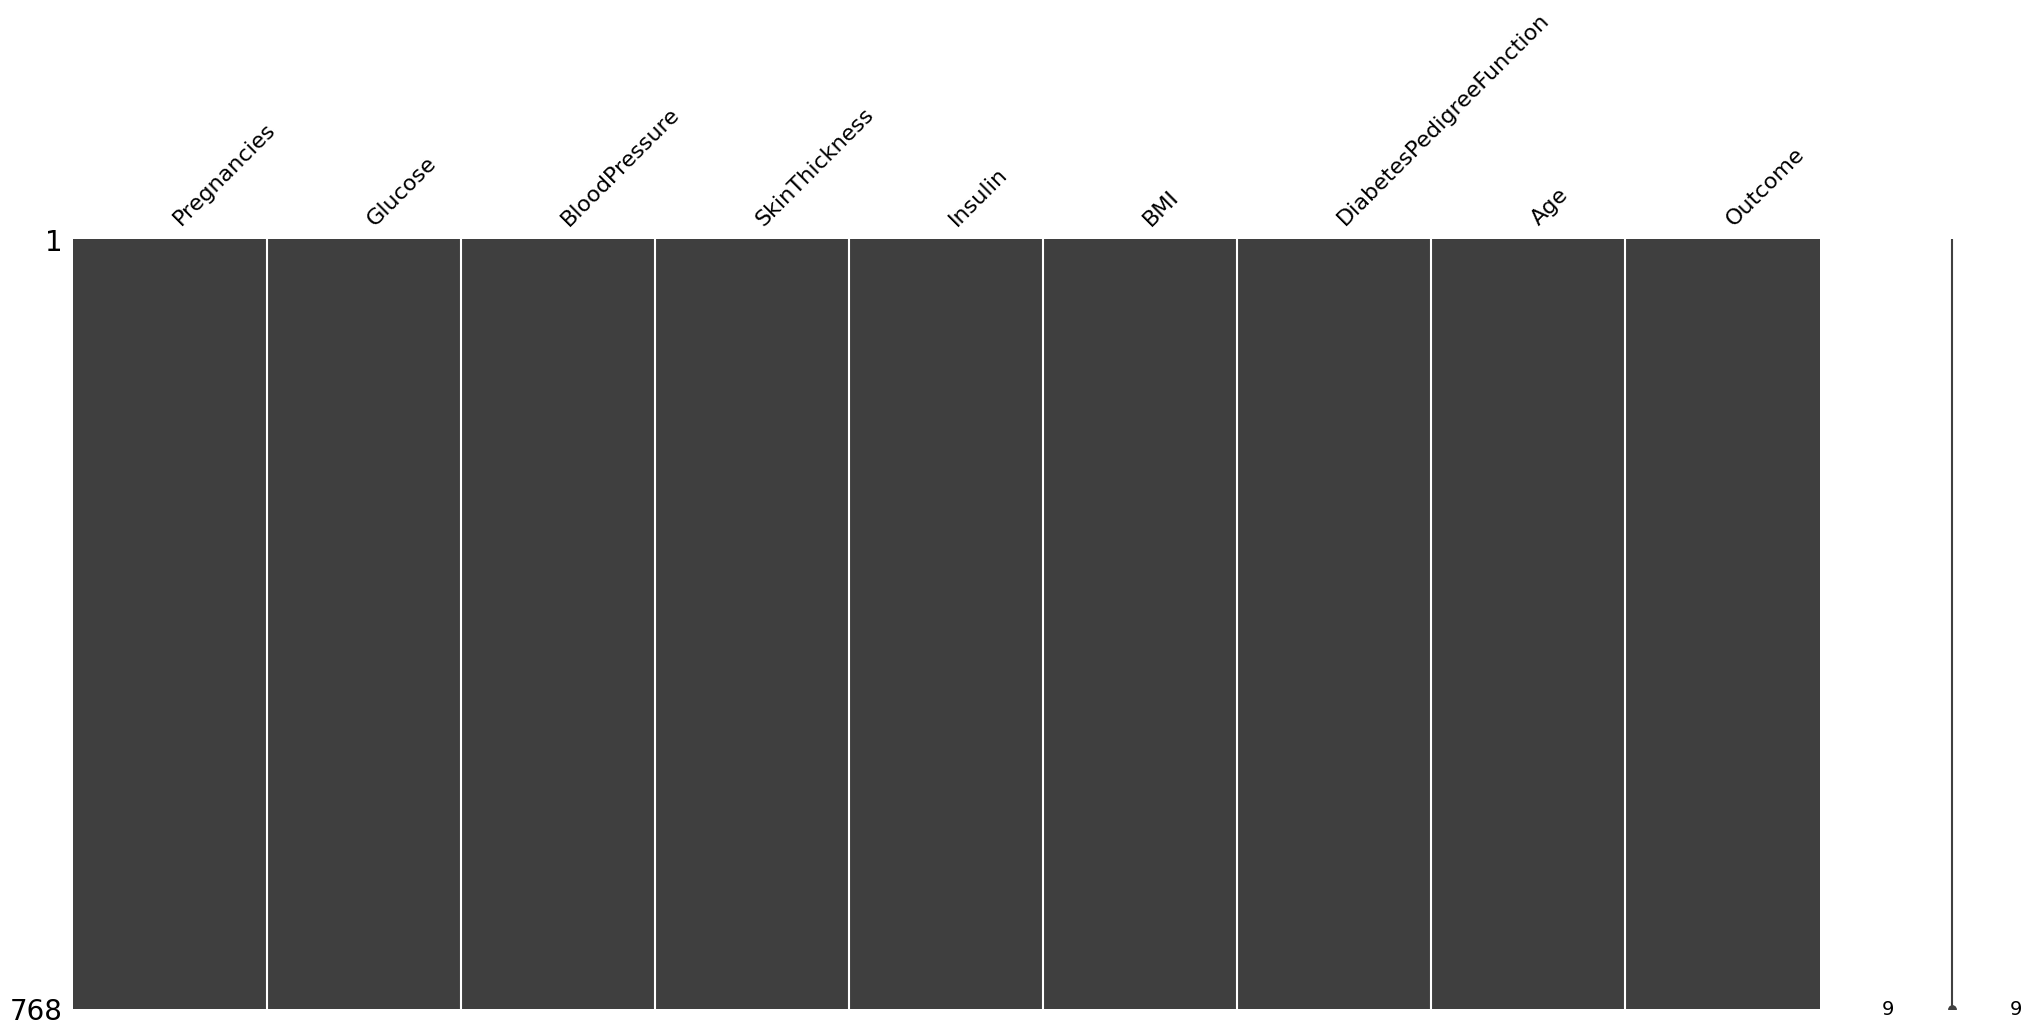

In [3]:
# Checking for missing values
msno.matrix(df)
plt.show()

In [4]:
# Cheking for Null Values
df[df.isna()].sum()

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

In [5]:
#  Cheking for Duplicate Values
df.duplicated().sum()

0

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


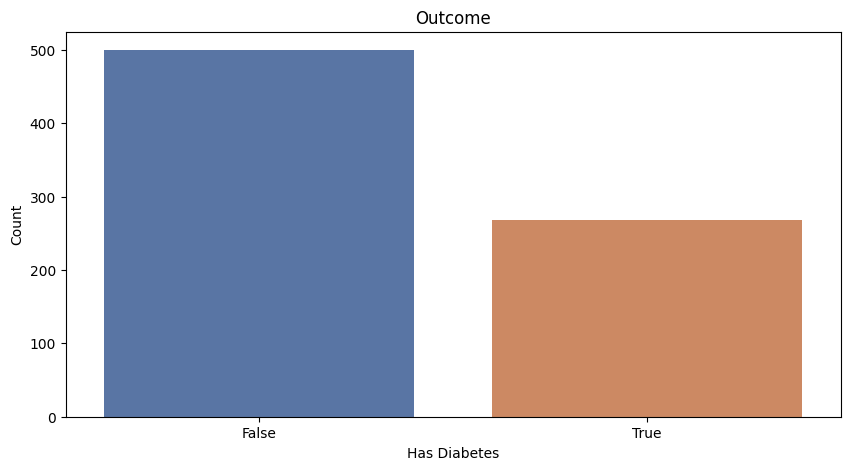

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Outcome', hue='Outcome', data=df, palette='deep', legend=False)
plt.title("Outcome")
plt.xlabel("Has Diabetes")
plt.xticks([0, 1], ('False', 'True'))
plt.ylabel("Count")
plt.show()

The graph indicates an imbalance in our dataset, with a split of 65/35 between classes 0 and 1, respectively. To address this issue, we can implement the following methods:

1. **Resampling Techniques**:
   - **Over-sampling**: Increase the number of minority class samples by duplicating or generating synthetic samples.
   - **Under-sampling**: Decrease the number of majority class samples by randomly removing instances or based on specific criteria.

2. **Generate Synthetic Samples**:
   - Utilize algorithms like Synthetic Minority Over-sampling Technique (SMOTE) to create synthetic samples for the minority class.

3. **Class Weights**:
   - Adjust the weights assigned to minority class samples during model training. This strategy penalizes misclassifications in the minority class more heavily than those in the majority class.


In [8]:
# # Determine the layout of subplots based on the number of columns
# num_cols = len(df.columns)-2
# num_rows = (num_cols + 1) // 2

# # Create subplots using seaborn
# fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

# # Plot histograms for all columns
# for i, column in enumerate(df.columns[:8]):
#     row = i // 2
#     col = i % 2
#     sns.histplot(df[column], ax=axes[row, col], kde=True)
#     axes[row, col].set_title(column + " Histogram")
#     axes[row, col].set_xlabel("Value")
#     axes[row, col].set_ylabel("Density")

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [9]:
# plt.figure(figsize=(10, 10))
# sns.pairplot(
#     df,
#     hue =cols[-1],
#     vars=cols[:8],
#     diag_kind='kde',
#     palette='deep'
# )
# plt.show()

The above plot shows a huge amount of data from our dataset. the areas of interest are the graphs where there is a clear distinction between people with and without diabetes. As can be seen, the variables dont seem to have any correlation to one another. Some clumping  can be seen in some of the graph, drawing a distinction between the two groups.

### Correlation Between Variables

In [10]:
# # Computer correlation matrix
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# fig, ax = plt.subplots(figsize=(20, 20))

# # Generate a custom diverging colourmap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(
#     corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#     square=True, linewidths=.5, cbar_kws={"shrink": .5},
#     annot=True
# )

# ax.set_title('Correlation Heatmap of the Variables')

# plt.show()

The plot above indicate that, overall, there's little correlation among the variables. However, some correlations are noticeable, prompting further exploration of specific variable pairs.

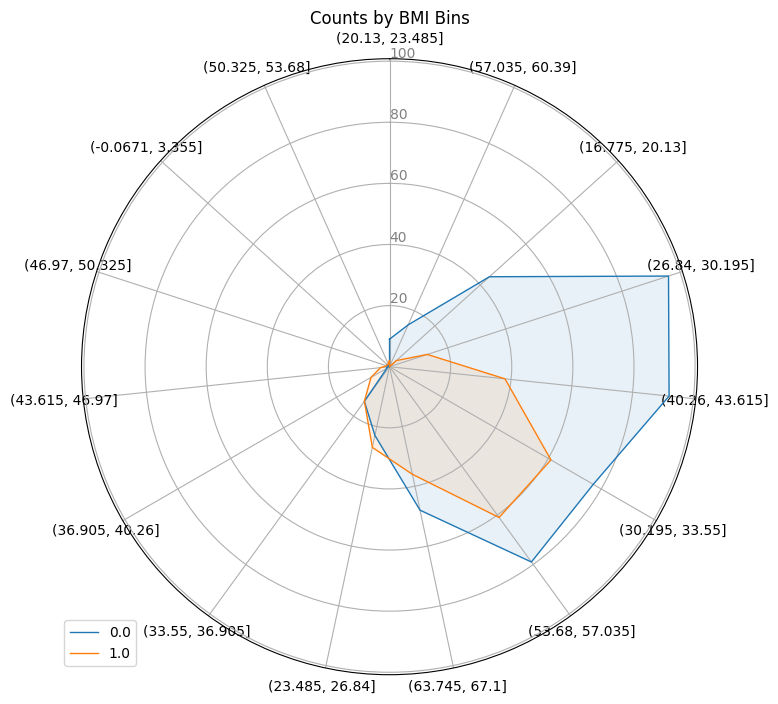

In [11]:
plot_radar(df, 20, "BMI","Outcome")

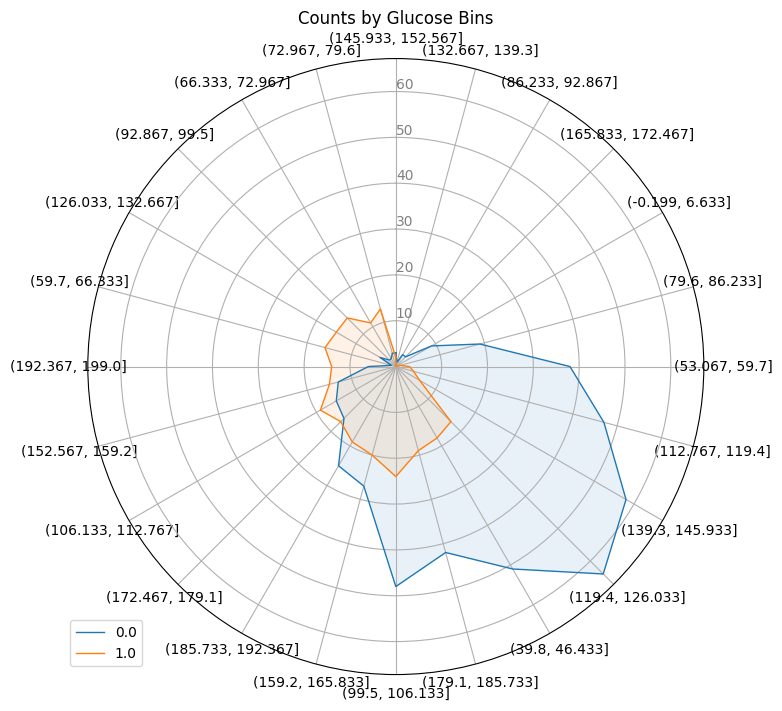

In [12]:
plot_radar(df, 30, "Glucose","Outcome")

## Outliers

### IQR method:

The Interquartile Range (IQR) method, a widely employed statistical technique, serves the purpose of identifying outliers within our dataset. By calculating the range between the first quartile (25th percentile) and the third quartile (75th percentile), this method delves into the central tendency of the data while simultaneously assessing its spread. Outliers, which fall beyond a certain range determined by the IQR, are flagged as potential anomalies.

#### Columns Suitable for Outlier Detection:

1. **Glucose**: Glucose levels are continuous and can vary widely, making them suitable for outlier detection. Extreme glucose values may indicate measurement errors or unusual physiological conditions, which are worth investigating.

2. **BloodPressure**: Blood pressure values also vary widely but typically fall within a certain range. Extreme values could signal measurement errors or health issues, making this column suitable for outlier detection.

3. **Insulin**: Like glucose, insulin levels can vary widely. Outliers in insulin levels may be indicative of measurement errors or physiological abnormalities, warranting further investigation.

4. **BMI**: Body Mass Index (BMI) typically ranges within certain limits based on physiological norms. Extreme values may indicate errors or unusual conditions such as severe obesity or malnutrition, making BMI suitable for outlier detection.

#### Columns Less Suitable for Outlier Detection:

1. **Pregnancies**: While pregnancies are discrete whole numbers, extreme values might not necessarily indicate outliers. The interpretation of outliers in pregnancies could be subjective and context-dependent, making it less suitable for outlier detection using the IQR method.

2. **SkinThickness**: Skin thickness might have a more defined range compared to other variables. Extreme values here could be outliers, but the definition of an outlier would depend on the context and the population being studied. Skin thickness may require additional domain knowledge for accurate outlier detection.

3. **DiabetesPedigreeFunction**: The diabetes pedigree function is a score derived from family history and might not have a clear upper or lower limit. Outliers here could be indicative of unusual family histories or data entry errors. The interpretation of outliers in this column may be less straightforward and may require additional context beyond the IQR method.

4. **Age**: While age generally has a defined range, outliers may still exist, particularly if the dataset includes individuals at the extremes of age or if there are data entry errors. Age may require additional considerations beyond the IQR method for accurate outlier detection, such as the demographic characteristics of the population being studied.


In [13]:
# outliers_cols = ["Glucose","BloodPressure","Insulin","BMI"]
# outliers_df = pd.DataFrame()

# for col in outliers_cols:
#     stats = df[col].describe()
    
#     IQR = stats['75%'] - stats['25%']
#     upper_limit = stats['75%'] + 1.5 * IQR
#     lower_limit = stats['25%'] - 1.5 * IQR
    
#     outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]

#     if  outliers.empty:
#         print(f'\n No outlier found in: {col}')
#     else:
#         print(f'\n -------------- {col} --------------')
#         outliers_df = pd.concat([outliers_df, outliers])
#     print(f"Number of Outliers: {len(outliers)}")
#     print(f'\n IQR: {IQR}')
#     print(f'\n Outliers Lower Bound: {lower_limit}')
#     print(f'\n Outliers Upper Bound: {upper_limit}')

# print(f'Total number of outlier: {len(outliers_df)}')

### Z-Score:

In [14]:
# all_outliers = pd.DataFrame()
# # Compute mean and standard deviation
# for col in outliers_cols:
#     mean = df[col].mean()
#     std_dev = df[col].std()

#     # Calculating z-scores
#     df['Z_Score'] = (df[col] - mean) / std_dev

#     # outliers threshold 
#     threshold = 2

#     # Identify outliers
#     outliers = df[abs(df['Z_Score']) > threshold]
#     all_outliers = pd.concat([all_outliers,outliers])
    
#     print(len(outliers),col)
# print(f'Total number of outlier: {len(all_outliers)}')


### Outlier Treatment Strategy 

In this analysis, we will adopt the assumption that outlier values are not due to measurement issues. This assumption is based on the observation that the higher and lower bounds identified using the interquartile range (IQR) method appear to be sensible data points within the context of the features being examined.

**Rationale**

The decision to retain outliers is driven by several factors:

1. **Significant Proportion of Outliers**: Out of the 768 data points in our dataset, 143 have been identified as outliers using the z-score method with a threshold of 2. While this represents a substantial portion of our data, it is essential to recognize that these outliers may contain valuable information that could contribute to the robustness and generalization of our classification model.

2. **Sensible Outlier Bounds**: The outliers identified through the IQR method do not appear to be extreme values that are likely to be inaccurate. Instead, they represent variations in the data that are within reasonable bounds given the nature of the features being analyzed (e.g., glucose levels, blood pressure, insulin levels, BMI).

**Strategy**

Given these considerations, we will proceed with retaining the outliers in our dataset and assess the performance of our classification model. By adopting this approach, we aim to develop a classification model that leverages the full range of information present in our dataset, including the outliers, to achieve accurate and generalizable predictions of diabetes status.

## over-sampling using SMOTE

Original dataset shape: Counter({0.0: 500, 1.0: 268})
Resampled dataset shape: Counter({1.0: 500, 0.0: 500})


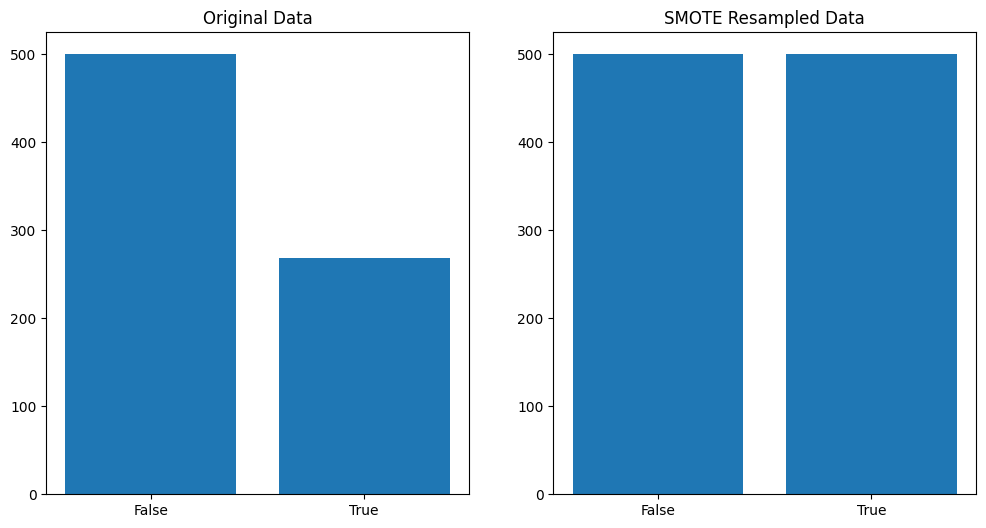

In [15]:
print("Original dataset shape:", Counter(y))


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


print("Resampled dataset shape:", Counter(y_resampled))

# Visualize the original and resampled class distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(Counter(y).keys(), Counter(y).values())
ax1.set_title('Original Data')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['False', 'True'])

ax2.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
ax2.set_title('SMOTE Resampled Data')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['False', 'True'])

plt.show()

X = X_resampled 
y = y_resampled


### Data Split



**Improved Generalization through Separate Normalisation**


Normalising the training and validation data separately can improve model generalization in a few ways:

1. **Prevents Data Leakage**: Separately normalising training and validation data prevents information leakage from the validation set into the training process, reducing the risk of overfitting.

2. **Reflects Real-World Variation**: By adapting to the specific characteristics of each dataset, separate normalisation better prepares the model for unseen data with potentially different distributions.

3. **Enhanced Stability**: Separate normalisation ensures that each dataset is scaled appropriately, leading to a more stable training process and better convergence.



In [16]:
split_ratio = 0.8

split = int(split_ratio * len(dataset))

# Calculate means and standard deviations for the training and validation sets
X_train_mean = np.mean(X[:split], axis=0)
X_train_std = np.std(X[:split], axis=0)

X_val_mean = np.mean(X[:split], axis=0)
X_val_std = np.std(X[:split], axis=0)

# Normalising
X_train = (X[:split] - X_train_mean) / X_train_std
X_val = (X[split:] - X_val_mean) / X_val_std

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y[:split], dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y[split:], dtype=torch.float32).reshape(-1, 1)


## Model Implementation

In [17]:
def create_model(n1, n2):
    model = nn.Sequential(
        nn.Linear(8, n1),
        nn.ReLU(),
        nn.Linear(n1, n2),
        nn.ReLU(),
        nn.Linear(n2, 1),
        nn.Sigmoid()
    )
    return model

param = {'batch_size': 16, 'lr': 0.01, 'n1': 32, 'n2': 64, 'num_ep': 100}
model = create_model(param["n1"], param['n2'])
# Define loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

### CUDA

In [18]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

## Training

In [19]:


n_epochs = param["num_ep"]
batch_size = param["batch_size"]

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

best_val_acc = 0
early_stop_counter = 0
patience = 20  # Number of epochs to wait before early stopping if validation accuracy doesn't improve

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i + batch_size]
        ybatch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Compute training accuracy, precision, recall, and F1 score
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_precisions.append(train_precision)

        train_recall = recall_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_recalls.append(train_recall)

        train_f1 = f1_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_f1_scores.append(train_f1)

        # Compute validation loss, accuracy, precision, recall, and F1 score
        y_pred_val = model(X_val)
        val_loss = loss_fn(y_pred_val, y_val)
        val_losses.append(val_loss.item())
        val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_precisions.append(val_precision)

        val_recall = recall_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_recalls.append(val_recall)

        val_f1 = f1_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_f1_scores.append(val_f1)

        # Check for early stopping
        if best_val_acc < val_accuracy:
            best_val_acc = val_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as validation accuracy has not improved for {patience} epochs.')
            break

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if early_stop_counter >= patience:
        break


Epoch [1/100], Train Loss: 0.3067, Val Loss: 0.7682, Train Accuracy: 0.7866, Val Accuracy: 0.5959
Epoch [2/100], Train Loss: 0.2611, Val Loss: 0.6876, Train Accuracy: 0.7850, Val Accuracy: 0.6192
Epoch [3/100], Train Loss: 0.2569, Val Loss: 0.6805, Train Accuracy: 0.7932, Val Accuracy: 0.6295
Epoch [4/100], Train Loss: 0.2507, Val Loss: 0.6766, Train Accuracy: 0.7932, Val Accuracy: 0.6373
Epoch [5/100], Train Loss: 0.2392, Val Loss: 0.6762, Train Accuracy: 0.7932, Val Accuracy: 0.6425
Epoch [6/100], Train Loss: 0.2424, Val Loss: 0.6560, Train Accuracy: 0.8013, Val Accuracy: 0.6503
Epoch [7/100], Train Loss: 0.2529, Val Loss: 0.6528, Train Accuracy: 0.8160, Val Accuracy: 0.6477
Epoch [8/100], Train Loss: 0.2250, Val Loss: 0.6483, Train Accuracy: 0.8192, Val Accuracy: 0.6528
Epoch [9/100], Train Loss: 0.2333, Val Loss: 0.6484, Train Accuracy: 0.8306, Val Accuracy: 0.6658
Epoch [10/100], Train Loss: 0.2318, Val Loss: 0.6332, Train Accuracy: 0.8306, Val Accuracy: 0.6632
Epoch [11/100], Tra

## Model Performance

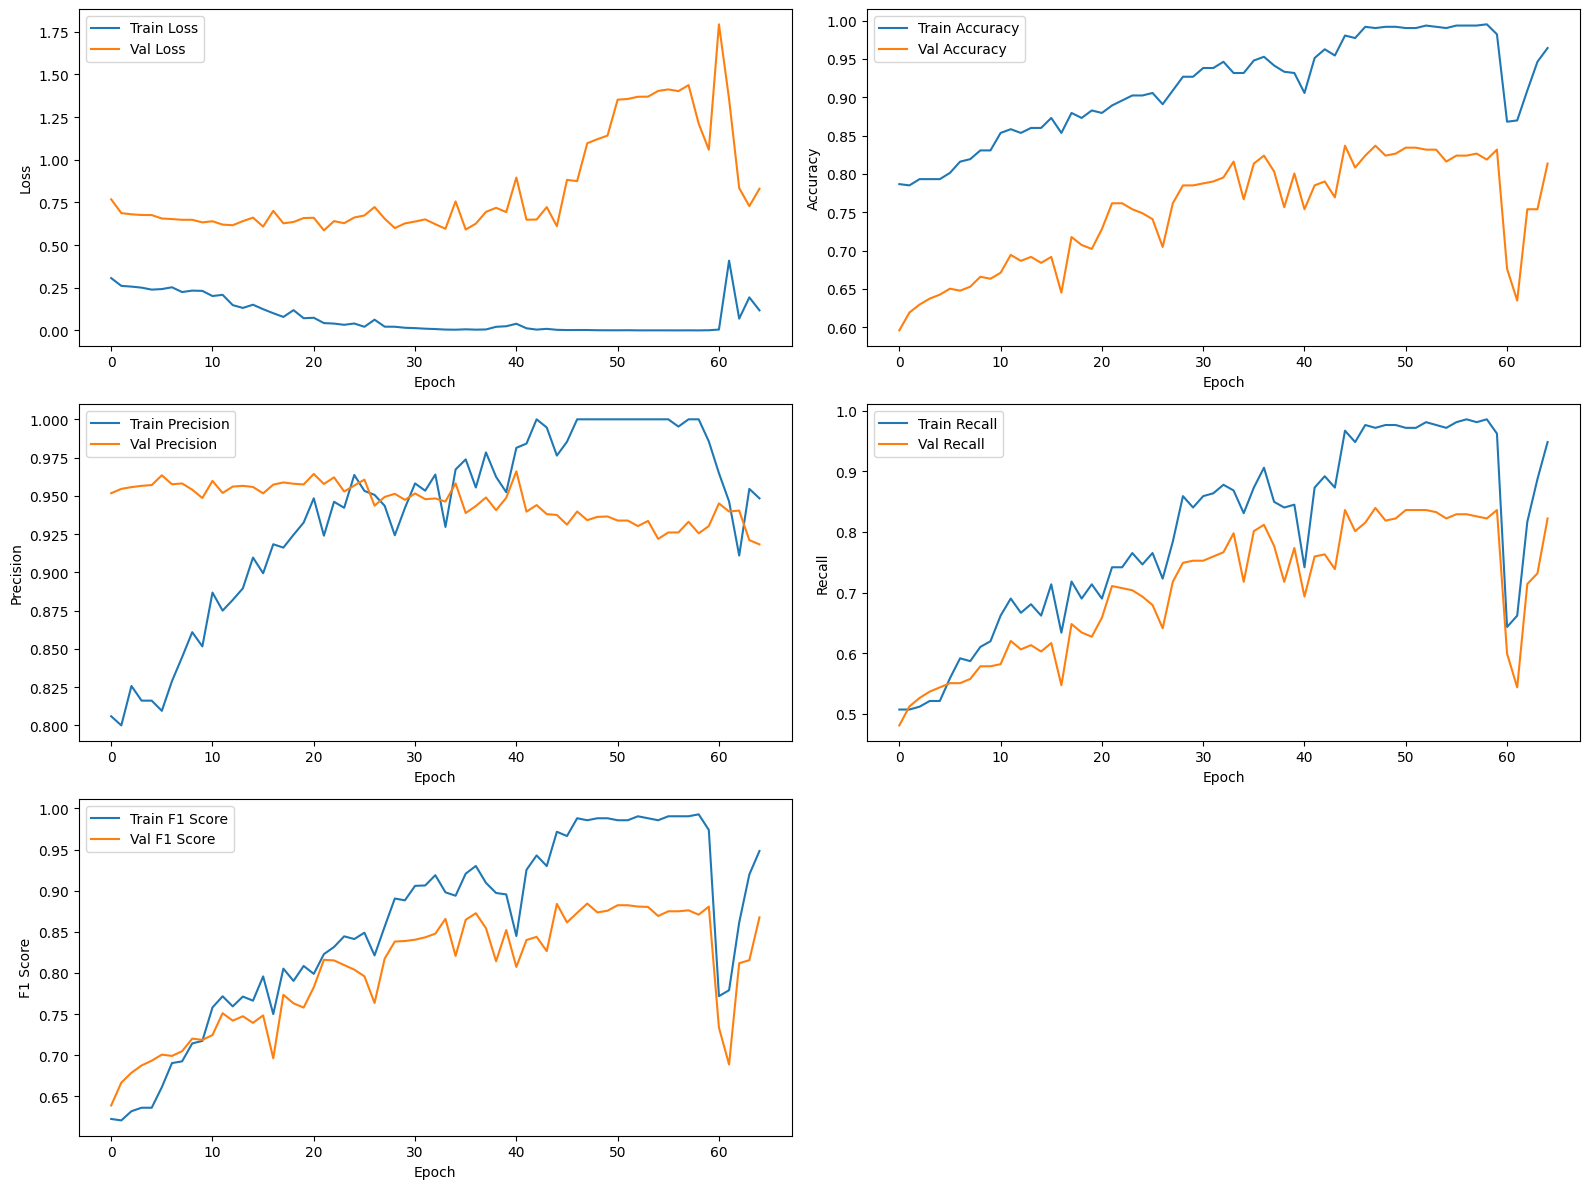

In [20]:
# validation metrics visualisation

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## optimization: 

Grid search for hyper parameter tunning

baysian optimization

explore early stopping

explore other simpler ml models

In [21]:
# # Hyperparameters for the grid search
# params_grid = {
#     'lr': [ 0.1],
#     'n1': [8, 16, 32],
#     'n2': [8, 16, 32],
#     'batch_size':[8,16,32,64],
#     'num_ep':[20,30,40,50]
# }
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# best_accuracy = 0.0
# best_hyperparams = {}


# # Training loop with grid search
# for params in ParameterGrid(params_grid):
#     batch_size = params['batch_size']
#     model = create_model(params['n1'], params['n2'])
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     loss_fn = nn.BCELoss()
#     model.to(device)
#     n_epochs = params['num_ep']

#     for epoch in range(n_epochs):
#         model.train()
#         for i in range(0, len(X_train), batch_size):
#             Xbatch = X_train[i:i+batch_size]
#             ybatch = y_train[i:i+batch_size]

#             # Forward pass
#             y_pred = model(Xbatch)
#             loss = loss_fn(y_pred, ybatch)

#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         train_losses.append(loss.item())

#         # Compute training accuracy, precision, recall, and F1 score
#         model.eval()
#         with torch.no_grad():
#             y_pred_train = model(X_train)
#             train_loss = loss_fn(y_pred_train, y_train)
#             train_losses.append(train_loss.item())
#             train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
#             train_accuracies.append(train_accuracy)

#             # Compute validation loss, accuracy, precision, recall, and F1 score
#             y_pred_val = model(X_val)
#             val_loss = loss_fn(y_pred_val, y_val)
#             val_losses.append(val_loss.item())
#             val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
#             val_accuracies.append(val_accuracy)
#         #print(f'Epoch [{epoch+1}/{n_epochs}], Params: {params}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

#     # Print the parameters and accuracy after each grid search
#     print(f'Params: {params}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

#     # Keep track of the best hyperparameters
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_hyperparams = params

# # Print the best hyperparameters and their accuracy
# print("Best hyperparameters:")
# print(best_hyperparams)
# print("Best accuracy:", best_accuracy)


**no Smote**: Best hyperparameters: {'batch_size': 64, 'lr': 0.01, 'n1': 8, 'n2': 8, 'num_ep': 40} Best accuracy: 0.8311688303947449



**with Smote**: 
Best hyperparameters:
{'batch_size': 32, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 40}
Best accuracy: 0.8293735980987549


{'batch_size': 64, 'lr': 0.1, 'n1': 32, 'n2': 16, 'num_ep': 50}
Best accuracy: 0.8367875218391418